# TD Deep Q-Network

# Tutorial - Deep Q-Learning 

Deep Q-Learning uses a neural network to approximate $Q$ functions. Hence, we usually refer to this algorithm as DQN (for *deep Q network*).

The parameters of the neural network are denoted by $\theta$. 
*   As input, the network takes a state $s$,
*   As output, the network returns $Q_\theta [a | s] = Q_\theta (s,a) = Q(s, a, \theta)$, the value of each action $a$ in state $s$, according to the parameters $\theta$.


The goal of Deep Q-Learning is to learn the parameters $\theta$ so that $Q(s, a, \theta)$ approximates well the optimal $Q$-function $Q^*(s, a) \simeq Q_{\theta^*} (s,a)$. 

In addition to the network with parameters $\theta$, the algorithm keeps another network with the same architecture and parameters $\theta^-$, called **target network**.

The algorithm works as follows:

1.   At each time $t$, the agent is in state $s_t$ and has observed the transitions $(s_i, a_i, r_i, s_i')_{i=1}^{t-1}$, which are stored in a **replay buffer**.

2.  Choose action $a_t = \arg\max_a Q_\theta(s_t, a)$ with probability $1-\varepsilon_t$, and $a_t$=random action with probability $\varepsilon_t$. 

3. Take action $a_t$, observe reward $r_t$ and next state $s_t'$.

4. Add transition $(s_t, a_t, r_t, s_t')$ to the **replay buffer**.

4.  Sample a minibatch $\mathcal{B}$ containing $B$ transitions from the replay buffer. Using this minibatch, we define the loss:

$$
L(\theta) = \sum_{(s_i, a_i, r_i, s_i') \in \mathcal{B}}
\left[
Q(s_i, a_i, \theta) -  y_i
\right]^2
$$
where the $y_i$ are the **targets** computed with the **target network** $\theta^-$:

$$
y_i = r_i + \gamma \max_{a'} Q(s_i', a', \theta^-).
$$

5. Update the parameters $\theta$ to minimize the loss, e.g., with gradient descent (**keeping $\theta^-$ fixed**): 
$$
\theta \gets \theta - \eta \nabla_\theta L(\theta)
$$
where $\eta$ is the optimization learning rate. 

6. Every $N$ transitions ($t\mod N$ = 0), update target parameters: $\theta^- \gets \theta$.

7. $t \gets t+1$. Stop if $t = T$, otherwise go to step 2.

In [3]:
# Imports
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import gym
from gym.wrappers import Monitor
import matplotlib.pyplot as plt

# from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path
import base64

# SEED = 42
# torch.manual_seed(SEED)
# np.random.seed(SEED)
# random.seed(SEED)

In [4]:
print(f"python --version = {sys.version}")
print(f"torch.__version__ = {torch.__version__}")
print(f"np.__version__ = {np.__version__}")
print(f"gym.__version__ = {gym.__version__}")

python --version = 3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) 
[GCC 9.4.0]
torch.__version__ = 1.10.1+cu102
np.__version__ = 1.21.4
gym.__version__ = 0.21.0


## Torch 101

>"The torch package contains data structures for multi-dimensional tensors and defines mathematical operations over these tensors. Additionally, it provides many utilities for efficient serializing of Tensors and arbitrary types, and other useful utilities. 
[...] provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions." 
[PyTorch](https://pytorch.org/docs/stable/index.html)


### Variable types

In [5]:
# Very similar syntax to numpy.
zero_torch = torch.zeros((3, 2))

print('zero_torch is of type {:s}'.format(str(type(zero_torch))))

# Torch -> Numpy: simply call the numpy() method.
zero_np = np.zeros((3, 2))
assert (zero_torch.numpy() == zero_np).all()

# Numpy -> Torch: simply call the corresponding function on the np.array.
zero_torch_float = torch.FloatTensor(zero_np)
print('\nFloat:\n', zero_torch_float)
zero_torch_int = torch.LongTensor(zero_np)
print('Int:\n', zero_torch_int)
zero_torch_bool = torch.BoolTensor(zero_np)
print('Bool:\n', zero_torch_bool)

# Reshape
print('\nView new shape...', zero_torch.view(1, 6))
# Note that print(zero_torch.reshape(1, 6)) would work too.
# The difference is in how memory is handled (view imposes contiguity).

# Algebra
a = torch.randn((3, 2))
b = torch.randn((3, 2))
print('\nAlgebraic operations are overloaded:\n', a, '\n+\n', b, '\n=\n', a+b )

# More generally, torch shares the syntax of many attributes and functions with Numpy.

zero_torch is of type <class 'torch.Tensor'>

Float:
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Int:
 tensor([[0, 0],
        [0, 0],
        [0, 0]])
Bool:
 tensor([[False, False],
        [False, False],
        [False, False]])

View new shape... tensor([[0., 0., 0., 0., 0., 0.]])

Algebraic operations are overloaded:
 tensor([[ 0.8874,  0.9873],
        [ 1.3418, -0.7137],
        [-0.7373, -0.0682]]) 
+
 tensor([[-1.6184, -0.2835],
        [ 0.6120,  0.2216],
        [ 1.4362,  0.7232]]) 
=
 tensor([[-0.7310,  0.7039],
        [ 1.9537, -0.4921],
        [ 0.6990,  0.6549]])


### Gradient management

In [6]:
# torch.Tensor is a similar yet more complicated data structure than np.array.
# It is basically a static array of number but may also contain an overlay to 
# handle automatic differentiation (i.e keeping track of the gradient and which 
# tensors depend on which).
# To access the static array embedded in a tensor, simply call the detach() method
print(zero_torch.detach())

# When inside a function performing automatic differentiation (basically when training 
# a neural network), never use detach() otherwise meta information regarding gradients
# will be lost, effectively freezing the variable and preventing backprop for it. 
# However when returning the result of training, do use detach() to save memory 
# (the naked tensor data uses much less memory than the full-blown tensor with gradient
# management, and is much less prone to mistake such as bad copy and memory leak).

# We will solve theta * x = y in theta for x=1 and y=2
x = torch.ones(1)
y = 2 * torch.ones(1)

# Actually by default torch does not add the gradient management overlay
# when declaring tensors like this. To force it, add requires_grad=True.
theta = torch.randn(1, requires_grad=True)

# Optimisation routine
# (Adam is a sophisticated variant of SGD, with adaptive step).
optimizer = optim.Adam(params=[theta], lr=0.1)

# Loss function
print('Initial guess:', theta.detach())

for _ in range(100):
    # By default, torch accumulates gradients in memory.
    # To obtain the desired gradient descent beahviour,
    # just clean the cached gradients using the following line:
    optimizer.zero_grad()
    
    # Quadratic loss (* and ** are overloaded so that torch
    # knows how to differentiate them)
    loss = (y - theta * x) ** 2
    
    # Apply the chain rule to automatically compute gradients
    # for all relevant tensors.
    loss.backward()
    
    # Run one step of optimisation routine.
    optimizer.step()
    
print('Final estimate:', theta.detach())
print('The final estimate should be close to', y)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Initial guess: tensor([1.3927])
Final estimate: tensor([1.9972])
The final estimate should be close to tensor([2.])


## Setting the environment

### 1 - Define the GLOBAL parameters

In [7]:
# Environment
env = gym.make("CartPole-v0")

# Discount factor
GAMMA = 0.99

# Batch size
BATCH_SIZE = 256
# Capacity of the replay buffer
BUFFER_CAPACITY = 16384 # 10000
# Update target net every ... episodes
UPDATE_TARGET_EVERY = 32 # 20

# Initial value of epsilon
EPSILON_START = 1.0
# Parameter to decrease epsilon
DECREASE_EPSILON = 200
# Minimum value of epislon
EPSILON_MIN = 0.05

# Number of training episodes
# N_EPISODES = 200 #Default
N_EPISODES = 1000

# Learning rate
LEARNING_RATE = 0.1

#Added by me
# env.seed(SEED)

### 2 - Replay buffer

In [8]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

# create instance of replay buffer
replay_buffer = ReplayBuffer(BUFFER_CAPACITY)

### 3 - Neural Network

In [9]:
class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

### 3.5 - Loss function and optimizer

In [10]:
# create network and target network
hidden_size = 128
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n


q_net = Net(obs_size, hidden_size, n_actions)
target_net = Net(obs_size, hidden_size, n_actions)

# objective and optimizer
objective = nn.MSELoss()
# optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)
optimizer = optim.SGD(params=q_net.parameters(), lr=LEARNING_RATE)

### Question 0 (to do at home, not during the live session)

With your own word, explain the intuition behind DQN. Recall the main parts of the aformentionned algorithm.

## Implementing the DQN

In [11]:
def get_q(states):
    """
    Compute Q function for a list of states
    """
    with torch.no_grad():
        states_v = torch.FloatTensor([states])
        output = q_net.forward(states_v).detach().numpy()  # shape (1, len(states), n_actions)
    return output[0, :, :]  # shape (len(states), n_actions)

#### Question 1

Implement the `choose_action` function.

In [12]:
def choose_action(state, epsilon):
    """
    ** TO BE IMPLEMENTED **
    
    Return action according to an epsilon-greedy exploration policy
    """
    if np.random.uniform() < epsilon:
        return env.action_space.sample()
    else :
        return np.argmax(get_q([state])[0])

#### Question 2

Implement the `eval_dqn` function.

In [13]:
def eval_dqn(n_sim=5):
    """
    ** TO BE IMPLEMENTED **
    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state = env_copy.reset()
        done = False
        while not done:
            action = choose_action(state, 0.0)
            state, reward, done, _ = env_copy.step(action)
            episode_rewards[i] += reward
    
    return episode_rewards

#### Question 3

Implement the `update` function

In [14]:
def update(state, action, reward, next_state, done, replay_buffer=replay_buffer, **kwargs):
    """
    ** TO BE COMPLETED **
    """
    
    # add data to replay buffer
    if done:
        next_state = None
    replay_buffer.push(state, action, reward, next_state)
    
    if len(replay_buffer) < BATCH_SIZE:
        return np.inf
    
    # get batch
    transitions = replay_buffer.sample(BATCH_SIZE)

    # Compute loss - TO BE IMPLEMENTED!
    # ---------------------------------------------------------------------------- #
    #                                  Build info                                  #
    # ---------------------------------------------------------------------------- #
    old_states = torch.FloatTensor([t[0] for t in transitions])
    actions = torch.LongTensor([t[1] for t in transitions]).view(-1, 1)
    rewards = torch.FloatTensor([t[2] for t in transitions]).view(-1, 1)
    it_is_done = torch.BoolTensor([type(t[3]) != np.ndarray for t in transitions]).view(-1)
    # --------------------------------- fill None -------------------------------- #
    next_states_preprocess = [t[3] for t in transitions]
    for i in range(len(next_states_preprocess)):
        if type(next_states_preprocess[i]) != np.ndarray:
            next_states_preprocess[i] = torch.zeros(obs_size).numpy()
    next_states = torch.FloatTensor(next_states_preprocess)
    # ---------------------------------------------------------------------------- #
    #                                    Forward                                   #
    # ---------------------------------------------------------------------------- #
    # --------------------------------- q network -------------------------------- #
    values  = q_net(old_states).gather(dim = 1 , index=actions).view(-1, 1) # take the logit of the taken action
    # ------------------------------ target network ------------------------------ #
    targets = target_net(next_states).max(dim=1)[0].detach().view(-1, 1)
    targets[it_is_done] = 0.0
    targets = GAMMA * targets + rewards
    # ----------------------------------- loss ----------------------------------- #
    loss = objective(values, targets)

    # Optimize the model - UNCOMMENT!
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.detach().numpy()

#### Question 4
Train a DQN on the `env` environment.
*Hint* The mean reward after training should be close to 200.

In [15]:
EVAL_EVERY = 5
REWARD_THRESHOLD = 199

def train(verbose = True, UPDATE_TARGET_EVERY= UPDATE_TARGET_EVERY,**kwargs):
    state = env.reset()
    epsilon = EPSILON_START
    ep = 0
    total_time = 0
    while ep < N_EPISODES:
        action = choose_action(state, epsilon)

        # take action and update replay buffer and networks
        next_state, reward, done, _ = env.step(action)
        loss = update(state, action, reward, next_state, done, **kwargs)

        # update state
        state = next_state

        # end episode if done
        if done:
            state = env.reset()
            ep   += 1
            if ( (ep+1)% EVAL_EVERY == 0):
                rewards = eval_dqn()
                if verbose:
                    print("episode =", ep+1, ", reward = ", np.mean(rewards))
                if np.mean(rewards) >= REWARD_THRESHOLD:
                    break

            # update target network
            if ep % UPDATE_TARGET_EVERY == 0:
                target_net.load_state_dict(q_net.state_dict())
            # decrease epsilon
            epsilon = EPSILON_MIN + (EPSILON_START - EPSILON_MIN) * \
                            np.exp(-1. * ep / DECREASE_EPSILON )    

        total_time += 1
    return total_time, ep+1

# Run the training loop
train()

# Evaluate the final policy
rewards = eval_dqn(20)
print("")
print("mean reward after training = ", np.mean(rewards))


/tmp/ipykernel_57/3682856721.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  states_v = torch.FloatTensor([states])


episode = 5 , reward =  9.2
episode = 10 , reward =  9.2
episode = 15 , reward =  16.0
episode = 20 , reward =  22.0
episode = 25 , reward =  28.2
episode = 30 , reward =  23.2
episode = 35 , reward =  9.4
episode = 40 , reward =  38.8
episode = 45 , reward =  33.8
episode = 50 , reward =  42.8
episode = 55 , reward =  9.4
episode = 60 , reward =  28.0
episode = 65 , reward =  20.6
episode = 70 , reward =  14.6
episode = 75 , reward =  101.4
episode = 80 , reward =  80.4
episode = 85 , reward =  13.2
episode = 90 , reward =  24.2
episode = 95 , reward =  12.4
episode = 100 , reward =  198.6
episode = 105 , reward =  170.4
episode = 110 , reward =  200.0

mean reward after training =  199.9


#### Question 5

Experiment the policy network.

(Showing a video with a jupyter notebook, you may try this cell with Chrome/Chromium instead of Firefox. Otherwise, you may skip this question.)

In [16]:
if False:
    def show_video():
        html = []
        for mp4 in Path("videos").glob("*.mp4"):
            video_b64 = base64.b64encode(mp4.read_bytes())
            html.append('''<video alt="{}" autoplay 
                          loop controls style="height: 400px;">
                          <source src="data:video/mp4;base64,{}" type="video/mp4" />
                     </video>'''.format(mp4, video_b64.decode('ascii')))
        ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
        
    env = Monitor(env, './videos', force=True, video_callable=lambda episode: True)

    for episode in range(2):
        done = False
        state = env.reset()
        while not done:
            action = choose_action(state, 0.0)
            state, reward, done, info = env.step(action)
    # env.close()
    # show_video()

### Experiments: Do It Yourself

Remember the set of global parameters:
```
# Environment
env = gym.make("CartPole-v0")

# Discount factor
GAMMA = 0.99

# Batch size
BATCH_SIZE = 256
# Capacity of the replay buffer
BUFFER_CAPACITY = 16384 # 10000
# Update target net every ... episodes
UPDATE_TARGET_EVERY = 32 # 20

# Initial value of epsilon
EPSILON_START = 1.0
# Parameter to decrease epsilon
DECREASE_EPSILON = 200
# Minimum value of epislon
EPSILON_MIN = 0.05

# Number of training episodes
N_EPISODES = 200

# Learning rate
LEARNING_RATE = 0.1
```

#### Question 6

Craft an experiment and study the influence of the `BUFFER_CAPACITY` on the learning process (speed of *convergence*, training curves...) 

buffer_possiblities =  [256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
buffer_capacity =  256 	..........	mean_episode =  137 	mean_time =  4055
buffer_capacity =  512 	..........	mean_episode =  171 	mean_time =  6932
buffer_capacity =  1024 	..........	mean_episode =  139 	mean_time =  4900
buffer_capacity =  2048 	..........	mean_episode =  145 	mean_time =  5428
buffer_capacity =  4096 	..........	mean_episode =  124 	mean_time =  3620
buffer_capacity =  8192 	..........	mean_episode =  167 	mean_time =  8782
buffer_capacity =  16384 	..........	mean_episode =  139 	mean_time =  4635
buffer_capacity =  32768 	..........	mean_episode =  161 	mean_time =  7639
buffer_capacity =  65536 	..........	mean_episode =  131 	mean_time =  3846


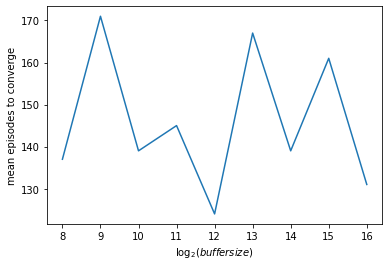

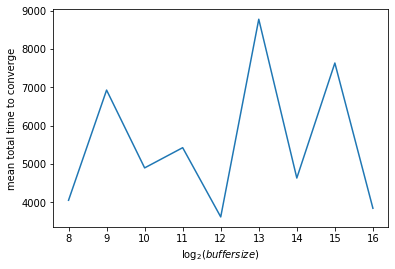

In [17]:
REPEAT = 10
start = 8 # 2**8 = 256 
iterations = 9 # 12
buffers_possiblities = [ 2**(start + i) for i in range(iterations) ]
episodes = []
times  = []
print("buffer_possiblities = ", buffers_possiblities)

for buffer_capacity in buffers_possiblities:
    print("buffer_capacity = ", buffer_capacity, "\t",end="")
    mean_episode = 0
    mean_time = 0
    for _ in range(REPEAT):
        print(".", end="")
        new_replay_buffer = ReplayBuffer(buffer_capacity)

        # Re-init all networks
        q_net = Net(obs_size, hidden_size, n_actions)
        target_net = Net(obs_size, hidden_size, n_actions)
        # Adam optimizer does have a memory, re-init it
        # optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)
        optimizer = optim.SGD(params=q_net.parameters(), lr=LEARNING_RATE)
        
        total_time, total_episode = train(verbose = False, replay_buffer=new_replay_buffer)
        mean_episode += total_episode
        mean_time += total_time
    mean_episode //= REPEAT
    mean_time //= REPEAT
    print("\tmean_episode = ", mean_episode, "\tmean_time = ", mean_time)
    episodes.append(mean_episode)
    times.append(mean_time)

# x axis in log
plt.plot(np.log2(buffers_possiblities), episodes)
plt.xlabel("$\log_2(buffer size)$")
plt.ylabel("mean episodes to converge")
plt.show()

plt.plot(np.log2(buffers_possiblities), times)
plt.xlabel("$\log_2(buffer size)$")
plt.ylabel("mean total time to converge")
plt.show()

#### Question 7

Craft an experiment and study the influence of the `UPDATE_TARGET_EVERY` on the learning process (speed of *convergence*, training curves...) 

update_possiblities =  [2, 4, 8, 16, 32, 64, 128]
update_target =  2 	..........	mean_episode =  66 	mean_time =  1850
update_target =  4 	..........	mean_episode =  59 	mean_time =  1557
update_target =  8 	..........	mean_episode =  76 	mean_time =  2276
update_target =  16 	..........	mean_episode =  83 	mean_time =  2381
update_target =  32 	..........	mean_episode =  145 	mean_time =  5533
update_target =  64 	..........	mean_episode =  297 	mean_time =  15065
update_target =  128 	..........	mean_episode =  544 	mean_time =  29453


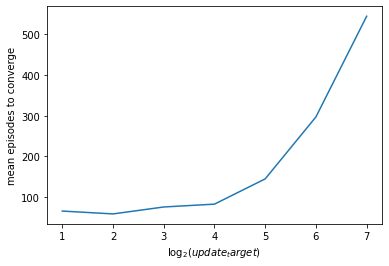

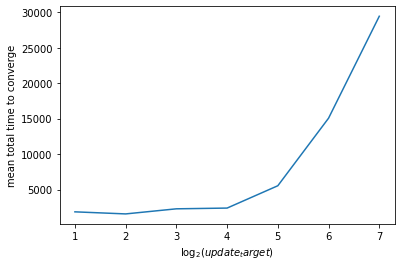

In [18]:
REPEAT = 10
start = 1
iterations = 7
update_possiblities = [ 2**(start + i) for i in range(iterations) ]
episodes = []
times  = []
print("update_possiblities = ", update_possiblities)

for update_target in update_possiblities:
    print("update_target = ", update_target, "\t",end="")
    mean_episode = 0
    mean_time = 0
    for _ in range(REPEAT):
        print(".", end="")
        new_replay_buffer = ReplayBuffer(BUFFER_CAPACITY)

        # Re-init all networks
        q_net = Net(obs_size, hidden_size, n_actions)
        target_net = Net(obs_size, hidden_size, n_actions)
        # Adam optimizer does have a memory, re-init it
        # optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)
        optimizer = optim.SGD(params=q_net.parameters(), lr=LEARNING_RATE)
        
        total_time, total_episode = train(verbose = False,UPDATE_TARGET_EVERY=update_target, replay_buffer=new_replay_buffer)
        mean_episode += total_episode
        mean_time += total_time
    mean_episode //= REPEAT
    mean_time //= REPEAT
    print("\tmean_episode = ", mean_episode, "\tmean_time = ", mean_time)
    episodes.append(mean_episode)
    times.append(mean_time)

# x axis in log
plt.plot(np.log2(update_possiblities), episodes)
plt.xlabel("$\log_2(update_target)$")
plt.ylabel("mean episodes to converge")
plt.show()

plt.plot(np.log2(update_possiblities), times)
plt.xlabel("$\log_2(update_target)$")
plt.ylabel("mean total time to converge")
plt.show()

#### Question 8

If you have the computer power to do so, try to do a grid search on those two hyper-parameters and comment the results. Otherwise, study the influence of another hyper-parameter.

In [19]:
REPEAT = 10
start = 1
iterations = 6
update_possiblities = [ 2**(start + i) for i in range(iterations) ]
print("update_possiblities = ", update_possiblities)
start = 8 # 2**8 = 256 
iterations = 9 # 12
buffers_possiblities = [ 2**(start + i) for i in range(iterations) ]
print("buffer_possiblities = ", buffers_possiblities)

all_episodes = []
all_times  = []


for buffer_capacity in buffers_possiblities:
    print("buffer_capacity = ", buffer_capacity)
    episodes = []
    times  = []
    for update_target in update_possiblities:
        print("\tupdate_target = ", update_target, "\t",end="")
        mean_episode = 0
        mean_time = 0
        for _ in range(REPEAT):
            print(".", end="")
            new_replay_buffer = ReplayBuffer(buffer_capacity)

            # Re-init all networks
            q_net = Net(obs_size, hidden_size, n_actions)
            target_net = Net(obs_size, hidden_size, n_actions)
            # Adam optimizer does have a memory, re-init it
            # optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)
            optimizer = optim.SGD(params=q_net.parameters(), lr=LEARNING_RATE)

            total_time, total_episode = train(verbose = False,UPDATE_TARGET_EVERY=update_target, replay_buffer=new_replay_buffer)
            mean_episode += total_episode
            mean_time += total_time
        mean_episode //= REPEAT
        mean_time //= REPEAT
        print("\tmean_episode = ", mean_episode, "\tmean_time = ", mean_time)
        episodes.append(mean_episode)
        times.append(mean_time)
    all_episodes.append(episodes)
    all_times.append(times)


np.save("all_episodes", all_episodes)
np.save("all_times", all_times)

update_possiblities =  [2, 4, 8, 16, 32, 64]
buffer_possiblities =  [256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
buffer_capacity =  256
	update_target =  2 	..........	mean_episode =  84 	mean_time =  2598
	update_target =  4 	..........	mean_episode =  57 	mean_time =  1585
	update_target =  8 	..........	mean_episode =  75 	mean_time =  2101
	update_target =  16 	..........	mean_episode =  102 	mean_time =  3176
	update_target =  32 	..........	mean_episode =  180 	mean_time =  7038
	update_target =  64 	..........	mean_episode =  401 	mean_time =  17759
buffer_capacity =  512
	update_target =  2 	..........	mean_episode =  52 	mean_time =  1339
	update_target =  4 	..........	mean_episode =  62 	mean_time =  1697
	update_target =  8 	..........	mean_episode =  67 	mean_time =  2139
	update_target =  16 	..........	mean_episode =  85 	mean_time =  2467
	update_target =  32 	..........	mean_episode =  224 	mean_time =  10573
	update_target =  64 	..........	mean_episode =  

In [20]:
all_episodes = np.load("all_episodes.npy")
all_times = np.load("all_times.npy")

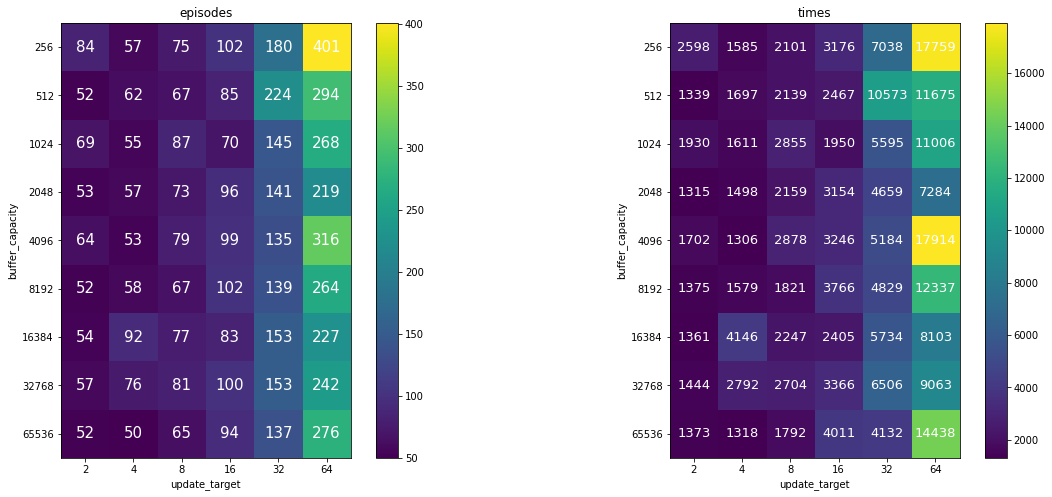

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

color_map = plt.cm.get_cmap("viridis")


ax[0].imshow(all_episodes, cmap=color_map)
ax[0].set_title("episodes")
ax[0].set_xticks(np.arange(len(update_possiblities)))
ax[0].set_yticks(np.arange(len(buffers_possiblities)))
ax[0].set_xticklabels(update_possiblities)
ax[0].set_yticklabels(buffers_possiblities)
ax[0].set_xlabel("update_target")
ax[0].set_ylabel("buffer_capacity")

ax[1].imshow(all_times, cmap=color_map)
ax[1].set_title("times")
ax[1].set_xticks(np.arange(len(update_possiblities)))
ax[1].set_yticks(np.arange(len(buffers_possiblities)))
ax[1].set_xticklabels(update_possiblities)
ax[1].set_yticklabels(buffers_possiblities)
ax[1].set_xlabel("update_target")
ax[1].set_ylabel("buffer_capacity")


for i in range(len(update_possiblities)):
    for j in range(len(buffers_possiblities)):
        e = all_episodes[j,i]
        ax[0].text(i, j, str(e), va='center', ha='center', color='w', fontsize=15)
        
        t = all_times[j,i]
        ax[1].text(i, j, str(t), va='center', ha='center', color='w', fontsize=13)
#show color bar
fig.colorbar(ax[0].imshow(all_episodes, cmap=color_map), ax=ax[0])
fig.colorbar(ax[1].imshow(all_times, cmap=color_map), ax=ax[1])
plt.show()

## Discretization

It is natural to use a function approximator like a neural network to approximate the $Q$ function in a continuous environment. Another natural but unscalable way to do handle continuous state-action space is **discretization**.

Discretize the environment of your choice (cartpole or mountain car or both) and run one of the algorithms that you know to compute an approximation of the optimal $Q$ function.

Once you are satisfied with your results, you may plot the *optimal phase diagram* of the system. For instance, you may get something like this for the mountain car environment.
![Phase diagram](./phase_plot.png)

In [ ]:
# TODO: Everything! This is an introduction to research and development